In [49]:
import re
import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 200)

# NLTK
import nltk
from nltk.corpus import PlaintextCorpusReader
from nltk import FreqDist
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.stem.porter import *

# Gensim
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Spacy for lemmatization
import spacy

# Plotting
# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import normal
%matplotlib inline
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [6]:
# Import dataset
data = pd.read_csv('Data/top_50.csv')
data.info()

data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23264 entries, 0 to 23263
Data columns (total 3 columns):
listing_id     23264 non-null float64
review         23264 non-null object
review_date    23264 non-null object
dtypes: float64(1), object(2)
memory usage: 545.3+ KB


,listing_id,review,review_date
0,15440.0,exquisite . private and . a long a charming venice . this is one of those rare place that you want to keep a secret so that it might be available when you visit again .,2010-01-14
1,15440.0,this is a real gem . pristine spotlessly clean with excellent features love the warmth of the small fireplace the complimentary bottle of wine snacks deluxe showerhead and leafy green patio too . ...,2010-01-18
2,15440.0,absolutely wonderful place with wonderful hosts . in a beautiful area of venice and even though parking can be tricky still well worth it ! ! !,2010-02-14
3,15440.0,this charming cottage is a real find and the hosts make this an amazing experience . beautiful walkstreet area of venice . parking was easy for me but i live in sf so i used to a short walk from t...,2010-02-26
4,15440.0,we enjoyed our stay here . we loved walking down the road and the cottage is about minutes away from lax and the beach .,2010-03-19


In [27]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
    
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    plt.xticks(rotation='vertical')
    ax.set(ylabel = 'Count')
    plt.show()

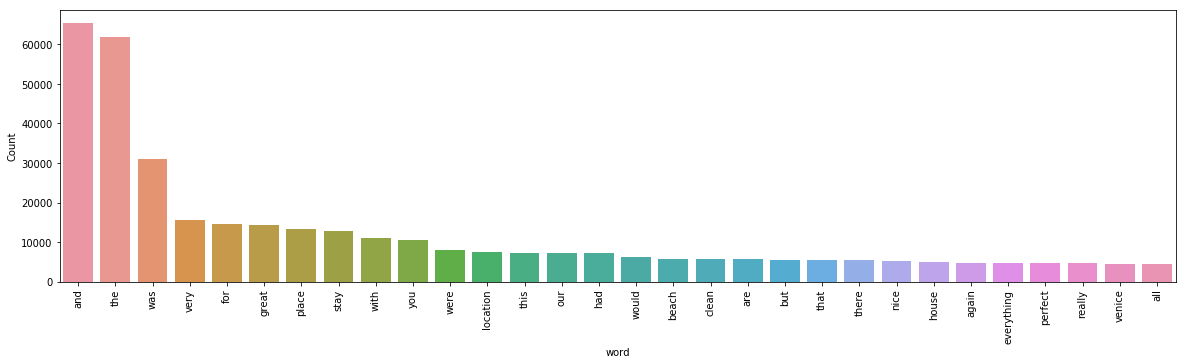

In [28]:
freq_words(data['review'])

In [29]:
# Remove unwanted characters, numbers and symbols
data['review'] = data['review'].str.replace("[^a-zA-Z#]", " ")

In [30]:
# Function to remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# Remove short words (length < 3)
data['review'] = data['review'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# Remove stopwords from the text
reviews = [remove_stopwords(r.split()) for r in data['review']]

# Make entire text lowercase
reviews = [r.lower() for r in reviews]

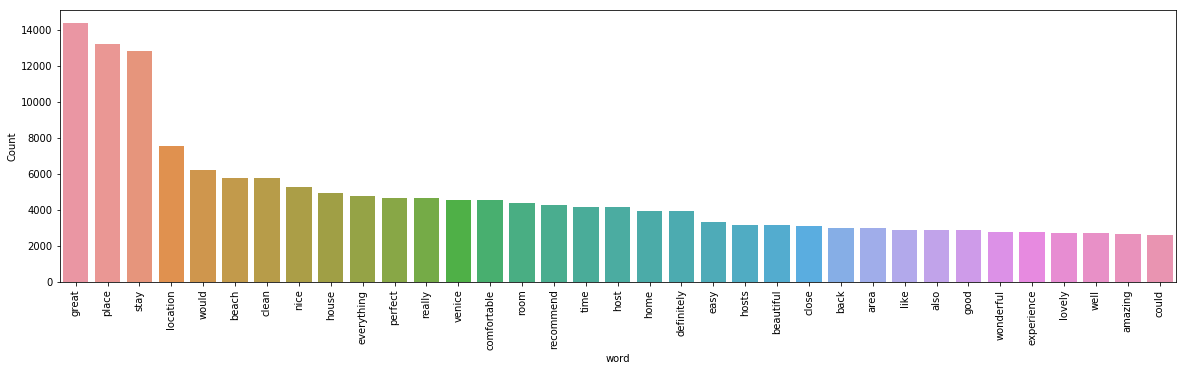

In [31]:
freq_words(reviews, 35)

In [32]:
# conda install -c conda-forge spacy
# python -m spacy download en # one time run

In [33]:
nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN', 'ADJ']): 
    
    # filter noun and adjective
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    
    return output

In [34]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['real', 'gem', 'pristine', 'spotlessly', 'clean', 'excellent', 'features', 'love', 'warmth', 'small', 'fireplace', 'complimentary', 'bottle', 'wine', 'snacks', 'deluxe', 'showerhead', 'leafy', 'green', 'patio', 'surrounding', 'neighborhood', 'idyllic', 'far', 'beach', 'made', 'simply', 'dreamy', 'weekend']


In [35]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1]) # print lemmatized review

['real', 'gem', 'pristine', 'clean', 'excellent', 'feature', 'warmth', 'small', 'fireplace', 'complimentary', 'bottle', 'wine', 'snack', 'deluxe', 'leafy', 'green', 'patio', 'neighborhood', 'idyllic', 'far', 'beach', 'dreamy', 'weekend']


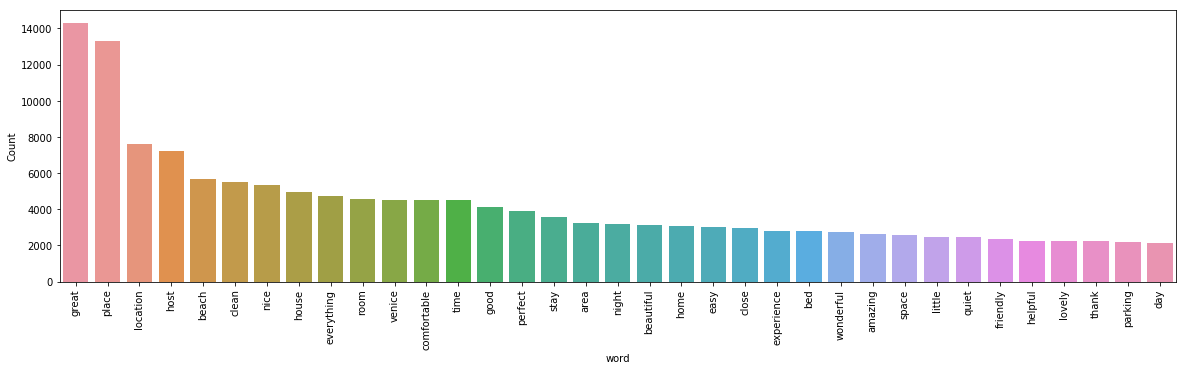

In [36]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

data['review'] = reviews_3

freq_words(data['review'], 35)

In [50]:
dictionary = corpora.Dictionary(reviews_2)
print(dictionary)

Dictionary(10151 unique tokens: ['available', 'charming', 'exquisite', 'long', 'place']...)


In [38]:
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

In [39]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=7, random_state=100,
                chunksize=1000, passes=50)

In [40]:
lda_model.print_topics()

[(0,
  '0.048*"place" + 0.025*"tracy" + 0.024*"beautiful" + 0.023*"amazing" + 0.015*"veronica" + 0.015*"home" + 0.015*"view" + 0.015*"los" + 0.013*"experience" + 0.013*"detail"'),
 (1,
  '0.061*"coffee" + 0.028*"water" + 0.028*"shower" + 0.018*"towel" + 0.017*"morning" + 0.017*"bed" + 0.016*"fridge" + 0.015*"touch" + 0.014*"snack" + 0.014*"bathroom"'),
 (2,
  '0.063*"jana" + 0.045*"house" + 0.045*"place" + 0.038*"host" + 0.035*"pool" + 0.035*"nice" + 0.027*"great" + 0.022*"everything" + 0.019*"friendly" + 0.018*"good"'),
 (3,
  '0.118*"great" + 0.073*"place" + 0.068*"location" + 0.040*"host" + 0.028*"everything" + 0.027*"perfect" + 0.025*"clean" + 0.021*"cottage" + 0.020*"stay" + 0.017*"comfortable"'),
 (4,
  '0.028*"night" + 0.025*"parking" + 0.024*"room" + 0.023*"bathroom" + 0.020*"bed" + 0.019*"space" + 0.017*"nice" + 0.016*"small" + 0.016*"street" + 0.014*"loft"'),
 (5,
  '0.027*"time" + 0.026*"house" + 0.022*"home" + 0.019*"room" + 0.017*"experience" + 0.017*"host" + 0.015*"first"

In [41]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.130100  0.140038       1        1  28.995287
5     -0.044206 -0.023329       2        1  18.872118
4      0.115722  0.254040       3        1  13.817440
3     -0.164255 -0.011217       4        1  12.313025
0     -0.036579 -0.234298       5        1  11.431386
2     -0.146568 -0.051071       6        1   8.993209
1      0.405985 -0.074163       7        1   5.577533, topic_info=      Category          Freq        Term         Total  loglift  logprob
term                                                                    
94     Default  14128.000000       great  14128.000000  30.0000  30.0000
133    Default   7620.000000    location   7620.000000  29.0000  29.0000
10     Default   6157.000000       beach   6157.000000  28.0000  28.0000
4      Default  13328.000000       place  13328.000000  27.0000  27.0000
10080  Default   2430.000000        jana   2430.000000  26.0000  26.0000
79     Default   4314.000000       house   4314.000000  25.0000  25.0000
8      Default   5251.000000      venice   5251.000000  24.0000  24.0000
35     Default   6752.000000        host   6752.000000  23.0000  23.0000
212    Default   1477.000000      coffee   1477.000000  22.0000  22.0000
101    Default   4481.000000        nice   4481.000000  21.0000  21.0000
248    Default   2774.000000       close   2774.000000  20.0000  20.0000
2171   Default   1371.000000        pool   1371.000000  19.0000  19.0000
76     Default   4694.000000  everything   4694.000000  18.0000  18.0000
146    Default   4143.000000        room   4143.000000  17.0000  17.0000
36     Default   2285.000000     parking   2285.000000  16.0000  16.0000
2383   Default   1244.000000       tracy   1244.000000  15.0000  15.0000
95     Default   2834.000000        home   2834.000000  14.0000  14.0000
152    Default   1986.000000    bathroom   1986.000000  13.0000  13.0000
122    Default   2120.000000  restaurant   2120.000000  12.0000  12.0000
12     Default   5026.000000       clean   5026.000000  11.0000  11.0000
241    Default   3404.000000       night   3404.000000  10.0000  10.0000
86     Default   1129.000000      shower   1129.000000   9.0000   9.0000
42     Default   1110.000000     cottage   1110.000000   8.0000   8.0000
135    Default   3814.000000     perfect   3814.000000   7.0000   7.0000
34     Default   2609.000000   beautiful   2609.000000   6.0000   6.0000
73     Default   2859.000000         bed   2859.000000   5.0000   5.0000
191    Default   2726.000000       space   2726.000000   4.0000   4.0000
40     Default   2891.000000     amazing   2891.000000   3.0000   3.0000
124    Default   1675.000000      street   1675.000000   2.0000   2.0000
93     Default   2367.000000    friendly   2367.000000   1.0000   1.0000
...        ...           ...         ...           ...      ...      ...
11      Topic7    121.984406      bottle    122.885338   2.8791  -5.2835
1680    Topic7    121.792336        item    122.694603   2.8790  -5.2850
1400    Topic7    121.635590     ceiling    122.540062   2.8790  -5.2863
2972    Topic7    117.426949        solo    118.329926   2.8788  -5.3215
5244    Topic7    116.963257        robe    117.866364   2.8787  -5.3255
1256    Topic7    116.148636    pressure    117.050407   2.8787  -5.3325
1503    Topic7     99.777321      pillow    100.679237   2.8774  -5.4844
274     Topic7     99.063530        soap     99.964684   2.8774  -5.4916
1276    Topic7     95.140045       maker     96.041878   2.8770  -5.5320
1723    Topic7     95.120224         apt     96.021904   2.8770  -5.5322
1107    Topic7     94.901428     concern     95.803833   2.8770  -5.5345
1355    Topic7     92.315872   necessary     93.218094   2.8767  -5.5621
1350    Topic7     87.624413     listing     88.526352   2.8762  -5.6143
3059    Topic7     85.669144    homemade     86.572205   2.8759  -5.6369
942     Topic7     82.159599   selection

In [ ]:
# Reference: https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/
# Maybe later, can make dictionaries for each listing and have independent analysis for reviews (cluster by listing)

In [46]:
dict = {"Value": ["Price","Amount","Rate","Cheap","Worth","Low","Money","Economical","Reasonable","Fee","Expensive"],
        "Location": ["Railway","View","Station","Airport","Distance","Far","Close","Convenient","Train","Metro"],   
        "Service": ["Desk","Check-in","Check-out","Reliable","Fast","Convenient"],
        "Meal": ["Drink","Breakfast","Spicy","Food","Tasty","Tea","Buffet","Bar","Restaurant","Dinner","Lunch","Brunch","Delicious"],
        "Facility": ["Pool","Spa","Wi-fi","Gymnasium","Gym","Internet","Ample","Parking","Wireless","Broken"],
        "Room": ["Bed","Dirty","Clean","Toilet","Bathroom","Shower","Dryer","Fridge","View"],
        "Quality": ["Satusfactory","Ample","Hygienic","Proper","Ambience","Odour","Smell",],
        "Staff": ["Good","Polite","Helpful","Friendly","Reliable","Quick"],
        "Surrounding": ["Landmark","Monument","Temple","Mosque","Church","Restaurant","Beach","Diner","Mall","Market"]}

In [54]:
# Convert all documents to TF Vectors
all_tf_vectors = [dictionary.doc2bow(doc) for doc in reviews_2]

In [58]:
# Label the trained data. Since the folder name is the label, I use the same labels.

all_data_as_dict = [{id:1 for (id, tf_value) in vec} for vec in all_tf_vectors]
print(all_data_as_dict[:10])

[{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1}, {10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1}, {4: 1, 8: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1}, {8: 1, 27: 1, 33: 1, 34: 1, 35: 1, 36: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1}, {10: 1, 42: 1, 51: 1, 52: 1, 53: 1, 54: 1}, {4: 1, 7: 1, 35: 1, 42: 1, 50: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1}, {8: 1, 10: 1, 33: 1, 34: 1, 35: 1, 38: 1, 42: 1, 53: 1, 54: 1, 57: 1, 64: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1}, {10: 1, 12: 1, 33: 1, 34: 1, 35: 1, 36: 1, 42: 1, 44: 1, 46: 1, 57: 1, 64: 1, 66: 1, 78: 1, 83: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1, 100: 1, 101: 1, 102:

In [ ]:
value_data = [(d, 'Crime') for d in all_data_as_dict[0:num_crime_docs]]
sports_data = [(d, 'Sports') for d in all_data_as_dict[num_crime_docs:]]
all_labeled_data = crime_data + sports_data